In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import sklearn.metrics as skm
import statsmodels.api as sm
import math
from scipy.stats import norm

df = pd.DataFrame(pd.read_pickle("../data/pricespaths.pickle")).T

In [85]:
df.head()


,SPY,SPY65C,SPY65P,SPY70C,SPY70P,SPY75C,SPY75P,SPY80C,SPY80P,SPY85C,...,SPY115C,SPY115P,SPY120C,SPY120P,SPY125C,SPY125P,SPY130C,SPY130P,SPY135C,SPY135P
0,"{'bid': [[99.99, 5], [99.98, 10], [99.97, 17],...","{'bid': [[35.07542612171024, 1], [34.964315010...","{'bid': [], 'ask': [[0.7976483439324655, 1], [...","{'bid': [[30.07533746514461, 1], [29.964226354...","{'bid': [], 'ask': [[0.7975596873668325, 1], [...","{'bid': [[25.10434881477817, 1], [24.993237703...","{'bid': [[0.10434881477816649, 1]], 'ask': [[0...","{'bid': [[20.183390224753246, 1], [20.07227911...","{'bid': [[0.18339022475324124, 1]], 'ask': [[0...","{'bid': [[15.357846354766435, 1], [15.24673524...",...,"{'bid': [], 'ask': [[0.4514008245996087, 1], [...","{'bid': [[14.729178602377385, 1], [14.61806749...","{'bid': [], 'ask': [[0.38646340541508273, 1], ...","{'bid': [[19.66424118319286, 1], [19.553130072...","{'bid': [], 'ask': [[0.372292637511263, 1], [0...","{'bid': [[24.65007041528904, 1], [24.538959304...","{'bid': [], 'ask': [[0.3697043075743229, 1], [...","{'bid': [[29.647482085352102, 1], [29.53637097...","{'bid': [], 'ask': [[0.3716370039645685, 1], [...","{'bid': [[34.649414781742344, 1], [34.53830367..."
1,"{'bid': [[99.69335079582171, 5], [99.683350795...","{'bid': [[34.75652672674887, 1], [34.645415615...","{'bid': [], 'ask': [[0.7753981531493603, 1], [...","{'bid': [[29.755214015438465, 1], [29.64410290...","{'bid': [], 'ask': [[0.7740854418389516, 1], [...","{'bid': [[24.782648306835338, 1], [24.67153719...","{'bid': [], 'ask': [[0.8015197332358273, 1], [...","{'bid': [[19.85997630161453, 1], [19.748865190...","{'bid': [[0.1566255057927935, 1]], 'ask': [[0....","{'bid': [[15.033934597693245, 1], [14.92282348...",...,"{'bid': [], 'ask': [[0.4444874445305442, 1], [...","{'bid': [[15.018914426486589, 1], [14.90780331...","{'bid': [], 'ask': [[0.38676934321898, 1], [0....","{'bid': [[19.96119632517502, 1], [19.850085214...","{'bid': [], 'ask': [[0.3739211848491767, 1], [...","{'bid': [[24.948348166805218, 1], [24.83723705...","{'bid': [], 'ask': [[0.3721132314470909, 1], [...","{'bid': [[29.946540213403136, 1], [29.83542910...","{'bid': [], 'ask': [[0.3755864772690731, 1], [...","{'bid': [[34.95001345922511, 1], [34.838902348..."
2,"{'bid': [[99.77173931773319, 5], [99.761739317...","{'bid': [[34.88547354073772, 1], [34.774362429...","{'bid': [[0.10373422300452728, 1]], 'ask': [[0...","{'bid': [[29.89183900150146, 1], [29.780727890...","{'bid': [[0.11009968376826207, 1]], 'ask': [[0...","{'bid': [[24.930356054288637, 1], [24.81924494...","{'bid': [[0.1486167365554379, 1]], 'ask': [[0....","{'bid': [[20.024548961182614, 1], [19.91343785...","{'bid': [[0.24280964344941697, 1], [0.13169853...","{'bid': [[15.224401437560417, 1], [15.11329032...",...,"{'bid': [], 'ask': [[0.4778168753097446, 1], [...","{'bid': [[14.973855335354326, 1], [14.86274422...","{'bid': [], 'ask': [[0.3976976511406653, 1], [...","{'bid': [[19.893736111185245, 1], [19.78262500...","{'bid': [], 'ask': [[0.3782554560150983, 1], [...","{'bid': [[24.874293916059678, 1], [24.76318280...","{'bid': [], 'ask': [[0.3742809153790163, 1], [...","{'bid': [[29.8703193754236, 1], [29.7592082643...","{'bid': [], 'ask': [[0.3765537531345702, 1], [...","{'bid': [[34.872592213179146, 1], [34.76148110..."
3,"{'bid': [[99.97992170993207, 5], [99.969921709...","{'bid': [[35.05176561800222, 1], [34.940654506...","{'bid': [], 'ask': [[0.7840661302923688, 1], [...","{'bid': [[30.062304961855048, 1], [29.95119385...","{'bid': [], 'ask': [[0.7946054741451951, 1], [...","{'bid': [[25.103732702331946, 1], [24.99262159...","{'bid': [[0.1138109923998678, 1]], 'ask': [[0....","{'bid': [[20.19926399902409, 1], [20.088152887...","{'bid': [[0.20934228909201352, 1]], 'ask': [[0...","{'bid': [[15.398261197791813, 1], [15.28715008...",...,"{'bid': [], 'ask': [[0.4906284903500544, 1], [...","{'bid': [[14.778484558195757, 1], [14.66737344...","{'bid': [], 'ask': [[0.4014996369514391, 1], [...","{'bid': [[19.68935570479714

In [86]:
df['SPY'][0]

{'bid': [[99.99, 5],
  [99.98, 10],
  [99.97, 17],
  [99.96, 31],
  [99.95, 56],
  [99.94, 100],
  [99.93, 177],
  [99.92, 316],
  [99.91, 562]],
 'ask': [[100.01, 5],
  [100.02, 10],
  [100.03, 17],
  [100.04, 31],
  [100.05, 56],
  [100.06, 100],
  [100.07, 177],
  [100.08, 316],
  [100.09, 562]]}

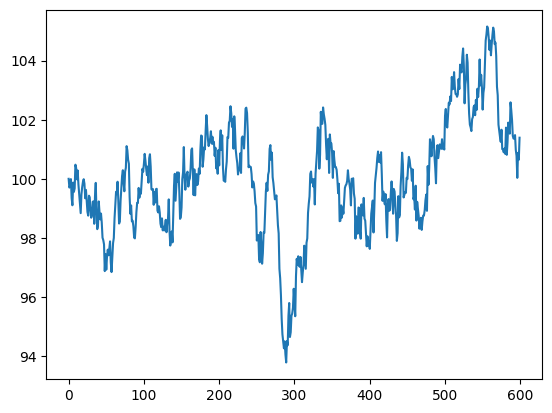

In [143]:
asset_price = np.zeros(len(df['SPY']))
for i in range(len(df['SPY'])):
    asset_price[i] = (df['SPY'][i]['bid'][0][0]+ df['SPY'][i]['ask'][0][0]) / 2
plt.plot(asset_price)
plt.show()

In [140]:
call_options = ['SPY65C', 'SPY70C', 'SPY75C', 'SPY80C', 'SPY85C', \
                'SPY90C', 'SPY95C', 'SPY100C', 'SPY105C', 'SPY110C', \
                'SPY115C', 'SPY120C', 'SPY125C', 'SPY130C', 'SPY135C']

put_options = ['SPY65P', 'SPY70P', 'SPY75P', 'SPY80P', 'SPY85P', \
                'SPY90P', 'SPY95P', 'SPY100P', 'SPY105P', 'SPY110P', \
                'SPY115P', 'SPY120P', 'SPY125P', 'SPY130P', 'SPY135P']

options = ['SPY65C', 'SPY70C', 'SPY75C', 'SPY80C', 'SPY85C', \
                'SPY90C', 'SPY95C', 'SPY100C', 'SPY105C', 'SPY110C', \
                'SPY115C', 'SPY120C', 'SPY125C', 'SPY130C', 'SPY135C', \
                'SPY65P', 'SPY70P', 'SPY75P', 'SPY80P', 'SPY85P', \
                'SPY90P', 'SPY95P', 'SPY100P', 'SPY105P', 'SPY110P', \
                'SPY115P', 'SPY120P', 'SPY125P', 'SPY130P', 'SPY135P']

past_bid = 0
past_ask = 0
for option_name in options:
    option_price = np.zeros(len(df[option_name]))
    for i in range(len(df[option_name])):
        current_bid = (df[option_name][i].get('bid') if df[option_name][i].get('bid') != []  else [[0]])[0][0]
        current_ask = (df[option_name][i].get('ask') if df[option_name][i].get('ask') != []  else [[0]])[0][0]
            
        option_price[i] = (current_bid + current_ask) / 2
        past_bid = current_bid
        past_ask = current_ask
    #plt.title(option_name)
    #plt.plot(option_price)
    #plt.show()


In [157]:
def d1(S,K,T,r,sigma):
    return(math.log(S/K)+(r+sigma**2/2.)*T)/(sigma*math.sqrt(T))
def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma)-sigma*math.sqrt(T)

def bs_call(S,K,T,r,sigma):
    return S*norm.cdf(d1(S,K,T,r,sigma))-K*math.exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma))
def bs_put(S,K,T,r,sigma):
    return K*math.exp(-r*T)-S*bs_call(S,K,T,r,sigma)
"""
expiry = '12-18-2022'
strike_price = 120

today = datetime.now()
one_year_ago = today.replace(year=today.year-1)

df = web.DataReader('SPY', 'yahoo', one_year_ago, today)

df = df.sort_values(by="Date")
df = df.dropna()
df = df.assign(close_day_before=df.Close.shift(1))
df['returns'] = ((df.Close - df.close_day_before)/df.close_day_before)

sigma = np.sqrt(252) * df['returns'].std()
#lcp = df['Close'].iloc[-1]
t = (datetime.strptime(expiry, "%m-%d-%Y") - datetime.utcnow()).days / 365
"""

timestamp = 300
lcp = asset_price[timestamp]
strike_price = 80
t = np.linspace(0.25, 0.0833, 600)
sigma = np.sqrt((0.25-t[timestamp])*365) * ((asset_price[timestamp] - asset_price[timestamp-1]) / asset_price[timestamp-1]).std() 

print('The Option Price is: ', bs_call(asset_price[timestamp], strike_price, t[timestamp], 0, sigma))
df['SPY80C'][timestamp]





The Option Price is:  15.799335096131486


/var/folders/bm/t6m4k8r90xxcy1x18tqmww_h0000gn/T/ipykernel_92946/1861878445.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  return(math.log(S/K)+(r+sigma**2/2.)*T)/(sigma*math.sqrt(T))


{'bid': [[15.95903229329068, 1],
  [15.847921182179569, 3],
  [15.736810071068456, 5],
  [15.625698959957345, 8],
  [15.514587848846235, 11],
  [15.403476737735124, 13],
  [15.292365626624012, 15],
  [15.1812545155129, 17],
  [15.07014340440179, 19]],
 'ask': [[16.6812545155129, 1],
  [16.79236562662401, 3],
  [16.903476737735122, 5],
  [17.014587848846233, 8],
  [17.125698959957347, 11],
  [17.236810071068458, 13],
  [17.34792118217957, 15],
  [17.45903229329068, 17],
  [17.57014340440179, 19]]}

The Option Price is:  15.799335096131486


/var/folders/bm/t6m4k8r90xxcy1x18tqmww_h0000gn/T/ipykernel_92946/395207272.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  return(math.log(S/K)+(r+sigma**2/2.)*T)/(sigma*math.sqrt(T))
/Users/oliversmirnov/Documents/GitHub/uchicago-trading-2023/venv/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/oliversmirnov/Documents/GitHub/uchicago-trading-2023/venv/lib/python3.11/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/oliversmirnov/Documents/GitHub/uchicago-trading-2023/venv/lib/python3.11/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/bm/t6m4k8r90xxcy1x18tqmww_h0000gn/T/ipykernel_92946/941157629.py:9: RuntimeWarning: divide by zero encoun

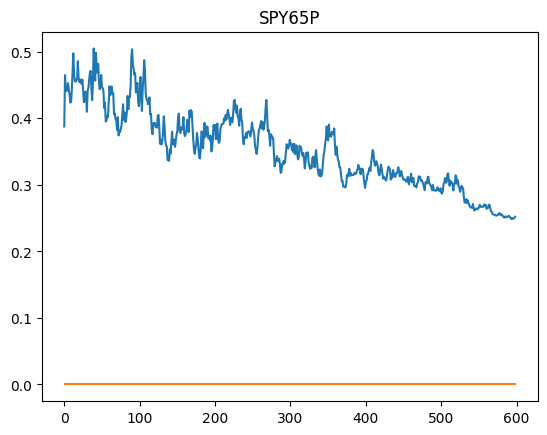

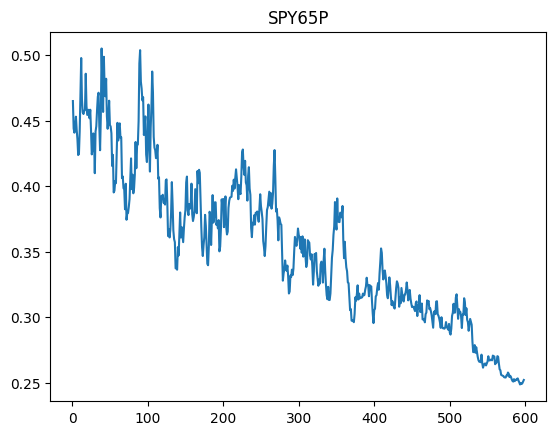

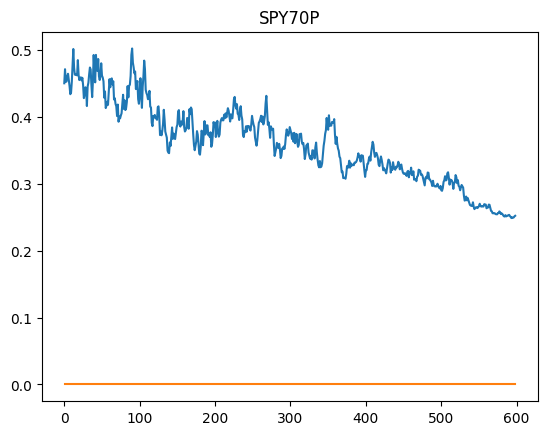

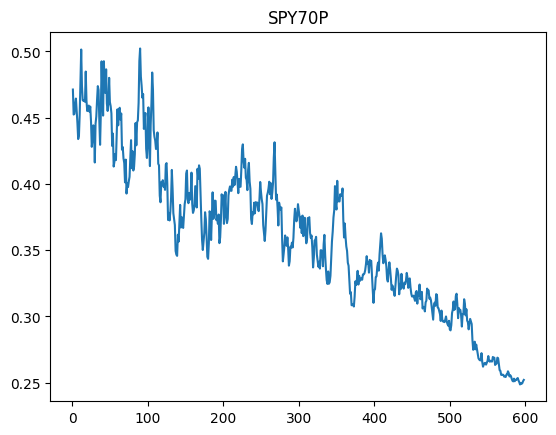

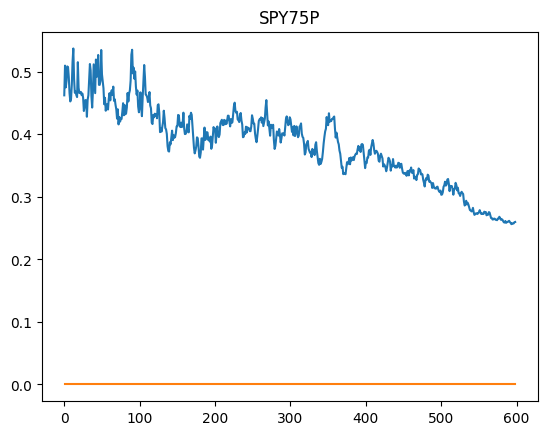

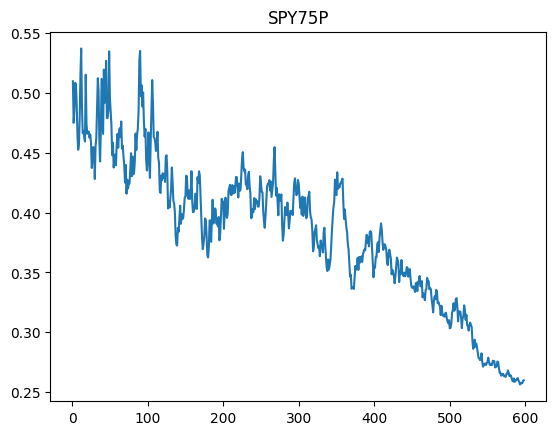

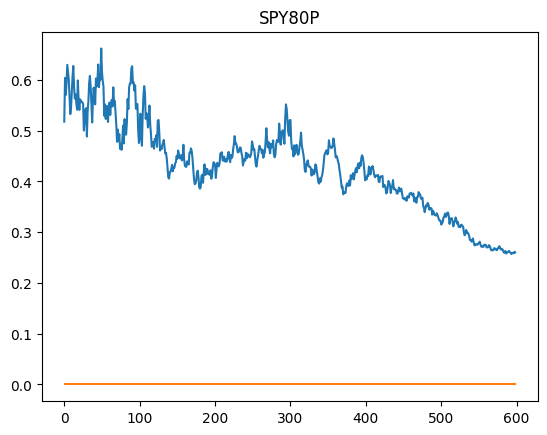

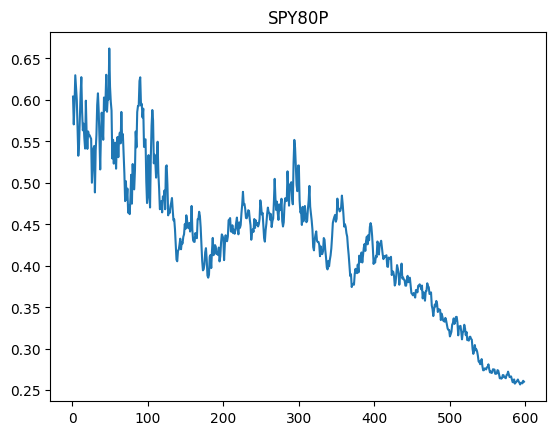

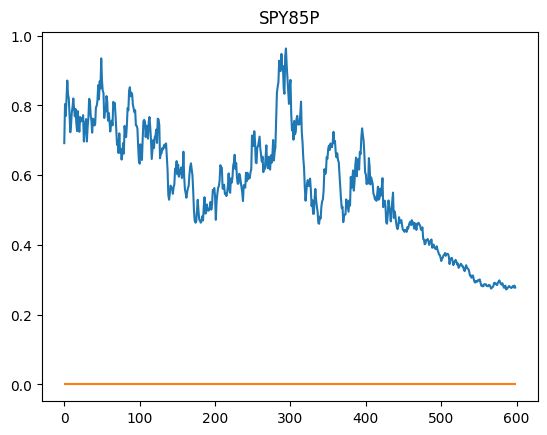

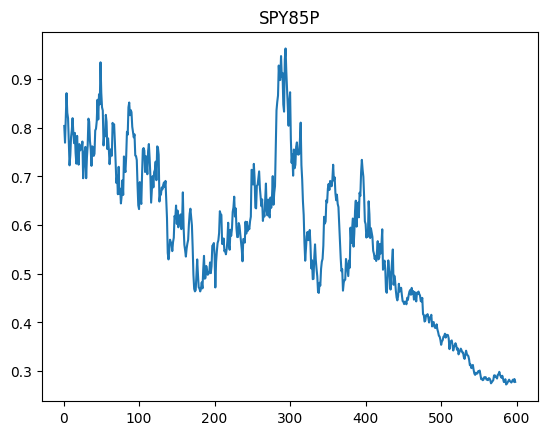

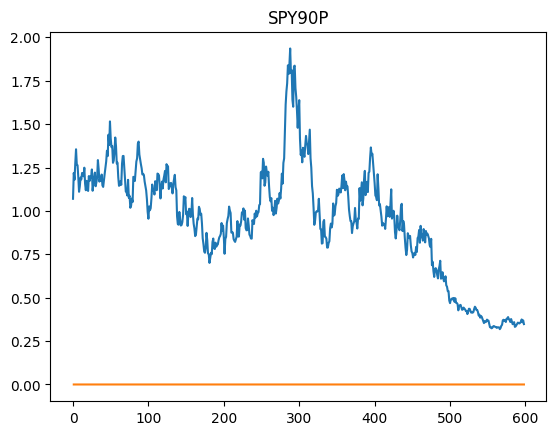

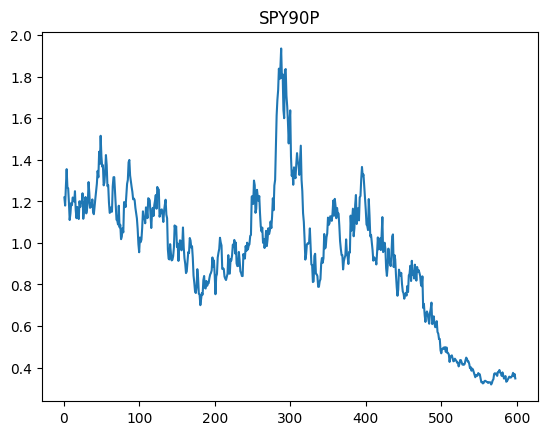

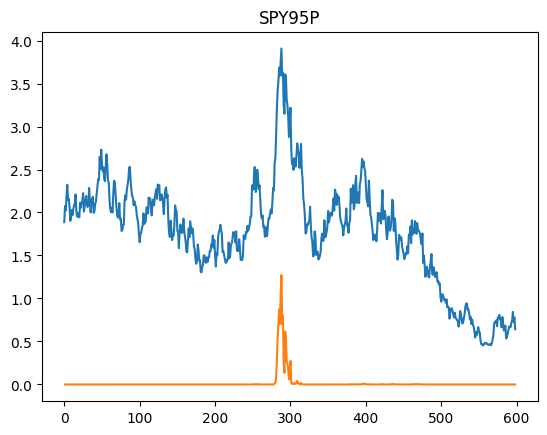

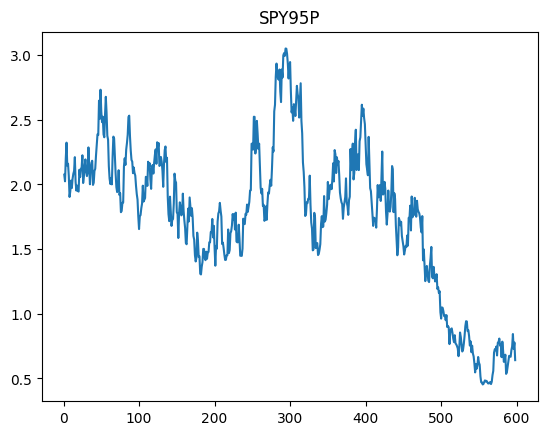

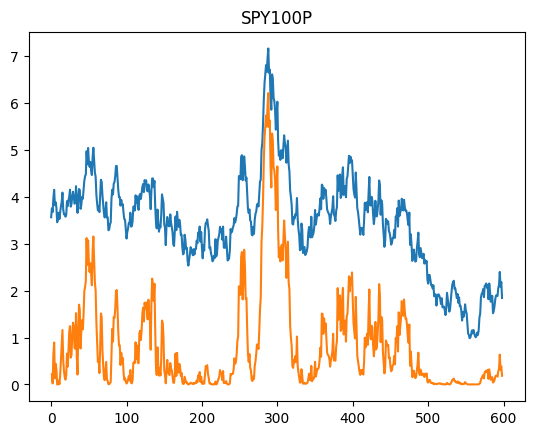

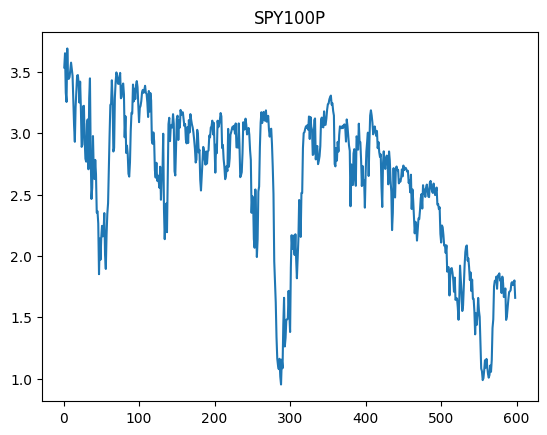

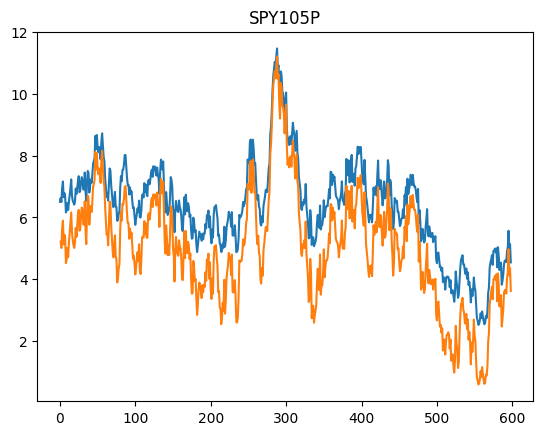

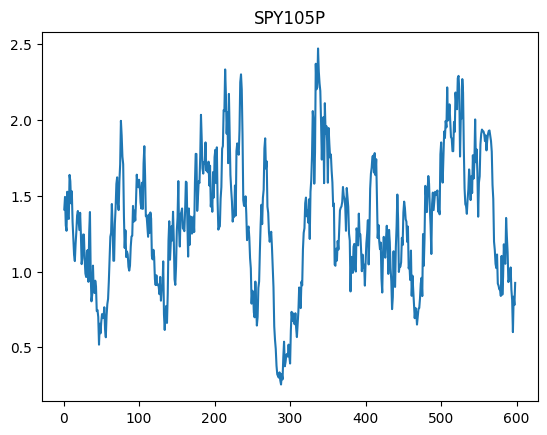

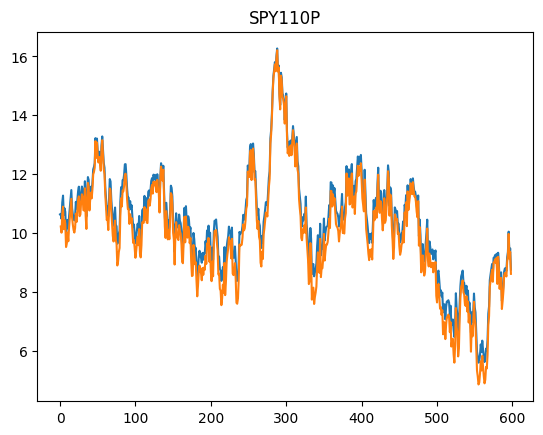

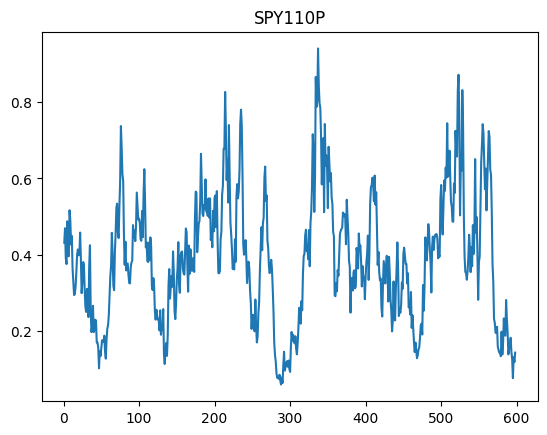

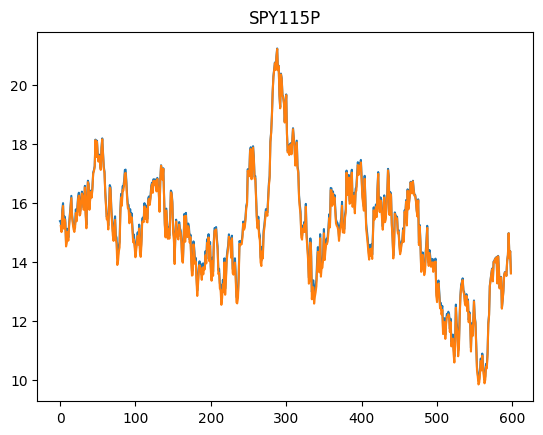

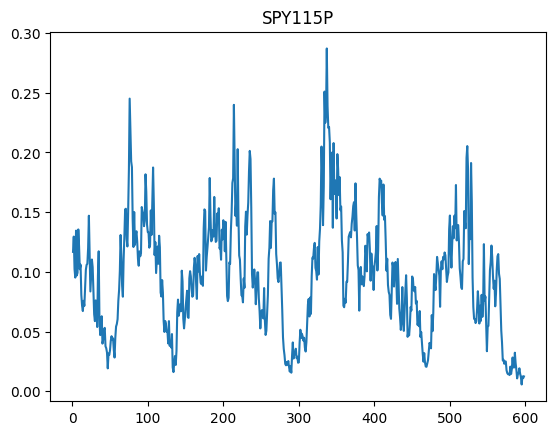

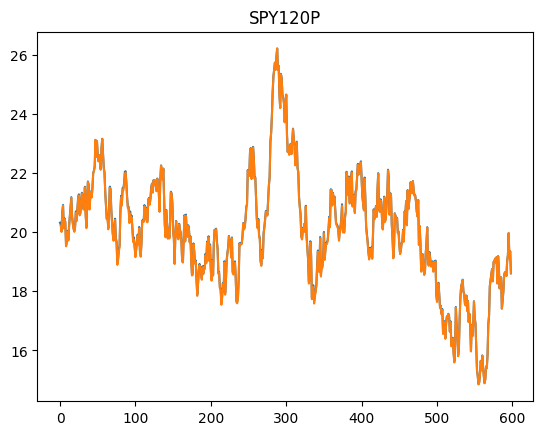

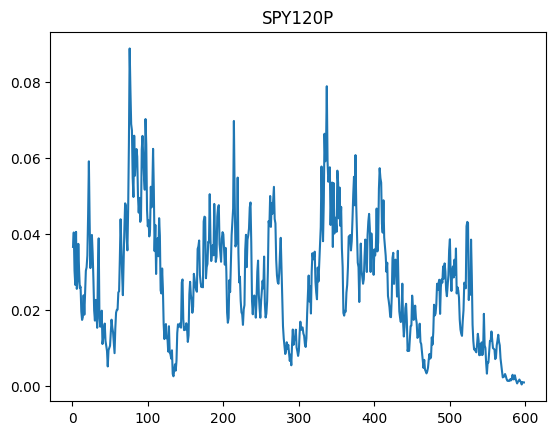

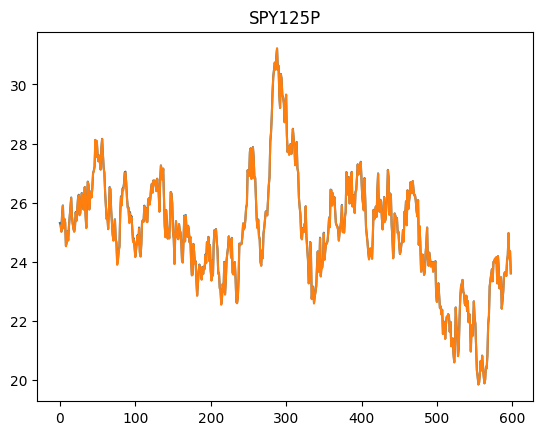

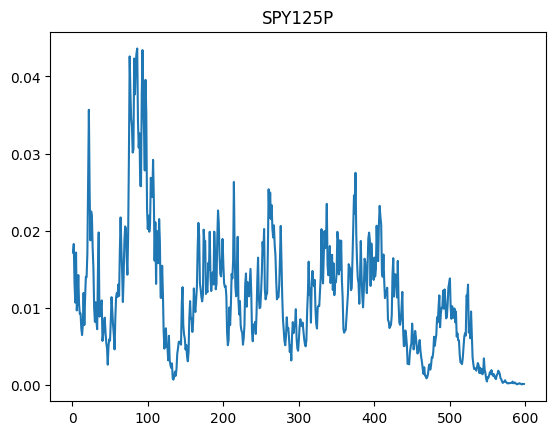

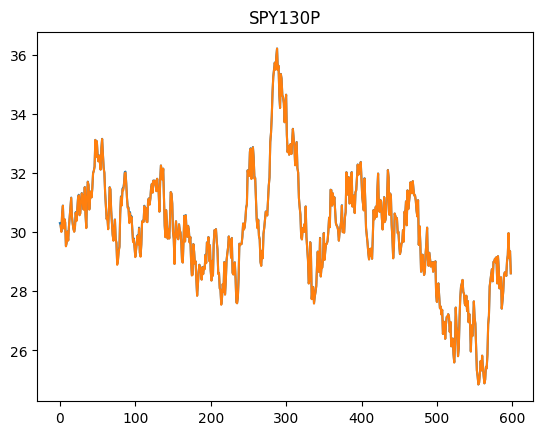

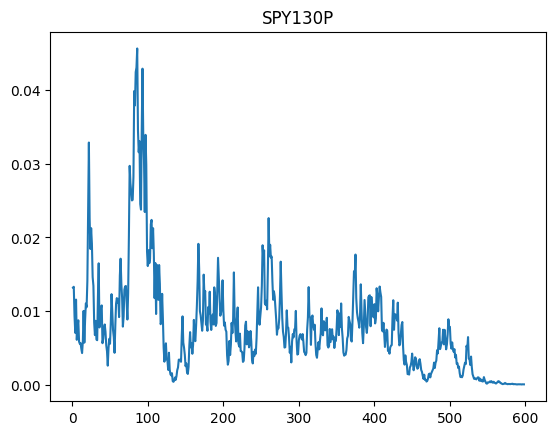

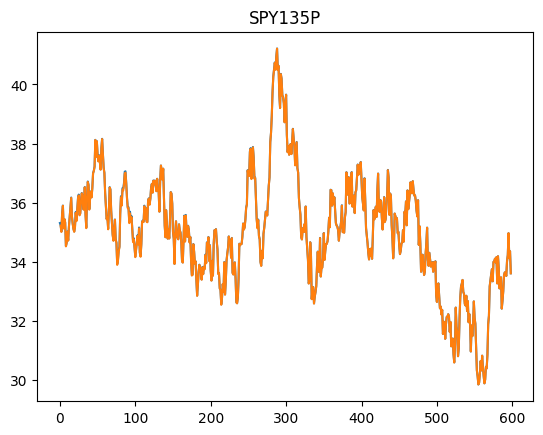

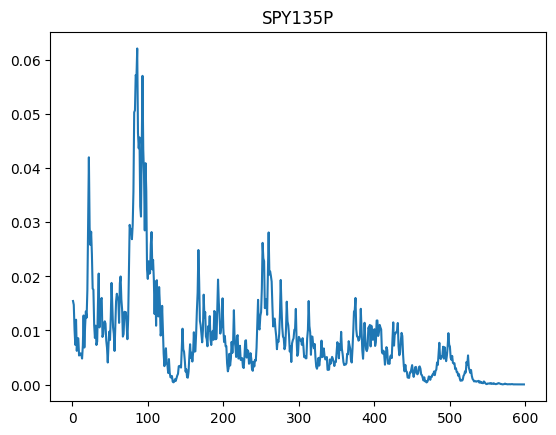

In [176]:
N = norm.cdf

def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)

def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    return K*np.exp(-r*T)*N(-d2) - S*N(-d1)

timestamp = 300
lcp = asset_price[timestamp]
strike_price = 80
t = np.linspace(0.25, 0.0833, 600)
sigma = np.sqrt((0.25-t[timestamp])*365) * ((asset_price[timestamp] - asset_price[timestamp-1]) / asset_price[timestamp-1]).std() 

print('The Option Price is: ', BS_CALL(asset_price[timestamp], strike_price, t[timestamp], 0, sigma))
df['SPY80C'][timestamp]



call_options = ['SPY65C', 'SPY70C', 'SPY75C', 'SPY80C', 'SPY85C', \
                'SPY90C', 'SPY95C', 'SPY100C', 'SPY105C', 'SPY110C', \
                'SPY115C', 'SPY120C', 'SPY125C', 'SPY130C', 'SPY135C']

put_options = ['SPY65P', 'SPY70P', 'SPY75P', 'SPY80P', 'SPY85P', \
                'SPY90P', 'SPY95P', 'SPY100P', 'SPY105P', 'SPY110P', \
                'SPY115P', 'SPY120P', 'SPY125P', 'SPY130P', 'SPY135P']

options = ['SPY80C']


past_bid = 0
past_ask = 0
j = 0
sp = [65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135]
for option_name in put_options:
    option_price = np.zeros(len(df[option_name]))
    bs_price = np.zeros(len(df[option_name]))
    for i in range(1, len(df[option_name])):
        current_bid = (df[option_name][i].get('bid') if df[option_name][i].get('bid') != []  else [[past_bid]])[0][0]
        current_ask = (df[option_name][i].get('ask') if df[option_name][i].get('ask') != []  else [[past_ask]])[0][0]
            
        option_price[i] = (current_bid + current_ask) / 2
        past_bid = current_bid
        past_ask = current_ask
        
        strike_price = sp[j]
        t = np.linspace(0.25, 0.0833, 600)
        sigma = np.sqrt((0.25-t[i])*365) * (((asset_price[1:i] - asset_price[:i-1]) / asset_price[:i-1]).std())
        bs_price[i] = BS_PUT(asset_price[i], strike_price, t[timestamp], 0, sigma)
    j+=1
        #print('The Option Price is: ', bs_call(asset_price[i], strike_price, t[timestamp], 0, sigma))
        
        
    plt.title(option_name)
    plt.plot(option_price[1:])
    plt.plot(bs_price[1:])
    plt.show()
    plt.title(option_name)
    plt.plot(option_price[1:]-bs_price[1:])
    plt.show()
